# Técnicas de clustering


## 1. Importar



In [1]:
# librerias

# manejo de datos
import numpy as np
import pandas as pd

# supresión de errores
import warnings
warnings.filterwarnings('ignore')

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# cluster kmeans
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# cluster jerárquico 
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, fcluster, linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.vq import whiten

# datos desbalanceados 
import imblearn
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss


In [2]:
# importar datos
path ='LiverPatient.csv'

raw_data =pd.read_csv(path, header =0)
# añadir nombres de las columnas
raw_data.columns= ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'AG', 'Status']
all_data = raw_data.copy()
raw_data.copy()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AG,Status
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1
...,...,...,...,...,...,...,...,...,...,...,...
577,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2
578,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,1
579,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,1
580,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,1


## 2. Pre-procesamiento 
Se transforma la variable 'Gender' a categórica. 

In [3]:
# Transformar gender a categorica 
all_data['Gender'].replace('Female',0 ,inplace=True)
all_data['Gender'].replace('Male',1,inplace=True)
all_data.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AG,Status
0,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,1,1.8,0.7,208,19,14,7.6,4.4,1.30,1


Se quitan las entradas con NANs del dataset. 

In [4]:
# Quitar missing values
all_data = all_data.dropna()
print ('Data whitout NaN Shape:', all_data.shape)

Data whitout NaN Shape: (578, 11)


## 2.1. Datos desbalanceados

Como se ha visto en el EDA, la variable 'Status' está fuertemente desbalanceada, así que se ha decidido evaluar algunas estrategias que ayudan a minimizar este problema: 
- Random oversampling: se generan datos aleatoriamente para que caso con menos datos iguale en número al que tiene más. 
- Random undersampling: de manera contraria, se reduce el dataset de manera aleatoria hasta que se igualan por abajo. 
- NearMiss: es otra técnica de undersampling que igualará las dos categorías
- SMOTE: utiliza k-vecinos mas cercanos para generar nuevos datos e igualar las categorías en el número más alto

In [5]:
# random oversampling 
oversample = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversample.fit_resample(all_data.iloc[:,0:10], all_data['Status'])
data_oversampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_oversampled.columns = all_data.columns
data_oversampled['Status'].value_counts()

1    413
2    413
Name: Status, dtype: int64

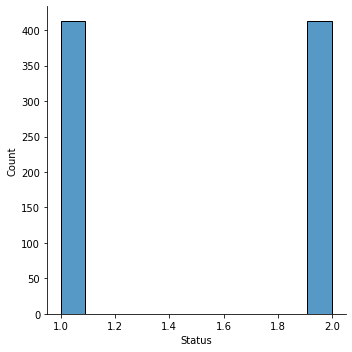

In [6]:
# Distribución de la variable respuesta
sns.displot(data_oversampled, x="Status")

In [7]:
# Random undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersample.fit_resample(all_data.iloc[:,0:10], all_data['Status'])
data_undersampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_undersampled.columns = all_data.columns
data_undersampled['Status'].value_counts()

1    165
2    165
Name: Status, dtype: int64

In [8]:
# NearMiss
nm = NearMiss()

x_nm, y_nm = nm.fit_resample(all_data.iloc[:,0:10], all_data['Status'])

data_nm = pd.concat([pd.DataFrame(x_nm), pd.DataFrame(y_nm)], axis=1)
data_nm.columns = all_data.columns
data_nm['Status'].value_counts()

1    165
2    165
Name: Status, dtype: int64

In [9]:
#SMOTE
sm = SMOTE()
x_sm, y_sm = sm.fit_resample(all_data.iloc[:,0:10], all_data['Status'])
data_sm = pd.concat([pd.DataFrame(x_sm), pd.DataFrame(y_sm)], axis=1)
data_sm.columns = all_data.columns
data_sm['Status'].value_counts()

1    413
2    413
Name: Status, dtype: int64

## 2.2 Normalización

Se crea un nuevo dataframe sin la variable 'Status' para aplicar sobre el los algoritmos de clusering: 

In [10]:
# modificando esto se prueban las distinas aproximaciones
technique = data_oversampled
# dataset sin la variable objetivo
data_st = technique.drop(['Status'], axis=1)
data_st

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AG
0,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74
1,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89
2,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00
3,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40
4,46,1,1.8,0.7,208,19,14,7.6,4.4,1.30
...,...,...,...,...,...,...,...,...,...,...
821,60,1,0.8,0.2,215,24,17,6.3,3.0,0.90
822,25,0,0.9,0.3,159,24,25,6.9,4.4,1.70
823,56,1,1.1,0.5,180,30,42,6.9,3.8,1.20
824,20,0,0.6,0.2,202,12,13,6.1,3.0,0.90


Se realiza un escalado de los datos utilizando la función whiten de la librería scipy. Reescala cada categoría en dividiendo por su desviación estándar, todas las observaciones tendrán la varianza igual a uno. 

In [11]:
# normalización de los datos
scaled_data = whiten(data_st.to_numpy())
pd.DataFrame(scaled_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,2.681254,1.696448,0.500422,0.481498,1.216770,0.426329,0.361281,6.080827,4.070904,3.152758
std,1.000606,1.000606,1.000606,1.000606,1.000606,1.000606,1.000606,1.000606,1.000606,1.000606
min,0.241841,0.000000,0.075021,0.041231,0.284096,0.064397,0.040782,2.525036,1.142133,0.969417
25%,1.934725,0.000000,0.150043,0.082463,0.771119,0.141673,0.093798,5.424151,3.426399,2.585113
50%,2.720706,2.285915,0.168798,0.123694,0.892874,0.199630,0.146815,6.172309,4.060917,3.231391
75%,3.506688,2.285915,0.356351,0.371082,1.271669,0.334864,0.285474,6.733428,4.822339,3.813041
max,5.441413,2.285915,14.066505,8.122568,9.514973,12.879373,20.101425,8.977904,6.979702,9.047894


## 3. K-means 

Las observaciones se van a agrupar en un número pre definido de clusters, estas agrupaciones se realizarán intentando minimizar la suma de la varianza interna de cada grupo. Este algoritmo necesita como input el número de clusters que va a generar. Asignará cada observación al centroide con el que tenga menos distancia. El valor del centroide se recalculará cada vez que se asigne un nuevo dato a ese cluster. 
Es una de las técnicas de clustering más utilizadas, pero tiene algunas desventajas, como la necesidad de indicar por adelantado el número de clusters o una asignación aleatoria de los centroides que realiza al principio. Además si el conjunto de datos tiene muchos outliers (como es el caso de este dataset) este tipo de técnica también presenta problemas. 

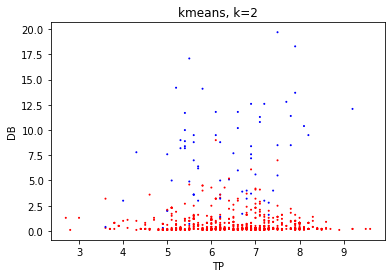

In [12]:
k = 2
x = technique['TP']
y = technique['DB']
kmeans = KMeans(n_clusters=k).fit(scaled_data)
labels = kmeans.predict(scaled_data)
technique['label'] = labels
# plot results
colores=['blue', 'red']
asignar=[]
for row in labels:
     asignar.append(colores[row])
plt.scatter(x, y, c=asignar, s=1)
plt.title('kmeans, k={}'.format(k))
plt.xlabel('TP')
plt.ylabel('DB')
plt.show()

### 3.1. K-means: métricas

Se utilizará una matriz de confusión para resumir los resultados de la clasificación por k-means con k=2. Se comprobarán los resultados frente a las dos categorías de la variable 'Status. 

In [13]:
data = np.array(technique['Status']).copy()
data[data == 1] = 0
data[data == 2] = 1

In [14]:
y_true = data 
y_pred = labels

<AxesSubplot:>

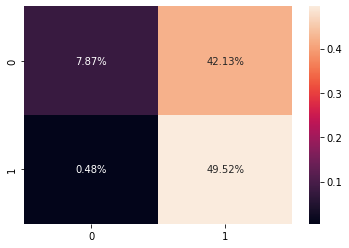

In [15]:
# matriz de confusion 
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')

La librería sklearn tiene una función específica que muestra métricas de algoritmos de Machine Learning ('classification_report'):
- precision: predicciones positivas 
- recall: capacidad de encontrar las entradas positivas 
- f1-score: media ponderada de la precission y recall 


In [16]:
class_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.94      0.16      0.27       413
           1       0.54      0.99      0.70       413

    accuracy                           0.57       826
   macro avg       0.74      0.57      0.48       826
weighted avg       0.74      0.57      0.48       826



## 4. Cluster Jerárquico

Estos algoritmos no requieren que se predefina el número de clusters. Normalmente se represetan ráficamente en forma de dendrograma. Se pueden clasificar en dos grupos, los aglomerativos y los divisivos. Las técnicas de cluster aglomerativo empiezan con todos los datos separados y van progresivamente iterando de manera que los mas cercanos se unen. De manera contraria los divisivos empiezan con todas las observaciones juntas y se van separando en función de la distancia entre puntos. Existen varios métodos que permiten medir dicha distancia: 
- Single: la menor distancia entre dos puntos de cada cluster
- Complete: mayor distancia entre dos puntos de cada cluster 
- Mean: media entre todos los puntos de los dos clusters 
- Centroid: distancia entre los centroides de los dos clusters 
- Ward: varianza mínima en un cluster


### 4.1. Clustering de una unión

In [17]:
# matriz de distancias
distance_matrix = linkage(scaled_data, method = 'single', metric = 'euclidean')

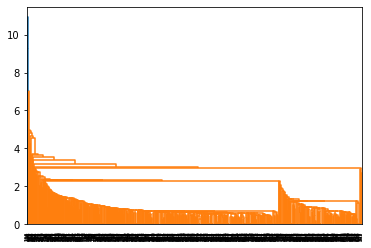

In [18]:
# crear el dendrograma
dn = dendrogram(distance_matrix)
plt.show()

In [19]:
data_st['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')

Text(0.5, 1.0, 'Hierarchical')

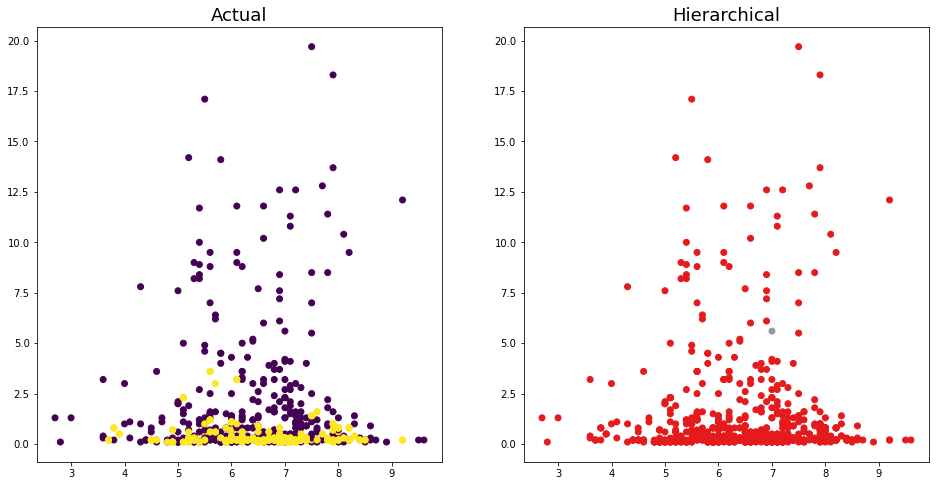

In [20]:
data_st['Status'] = technique.Status
 
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(data_st['TP'], data_st['DB'], c=data_st['Status'])
axes[1].scatter(data_st['TP'], data_st['DB'], c=data_st['cluster_labels'], cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Hierarchical', fontsize=18)

<AxesSubplot:>

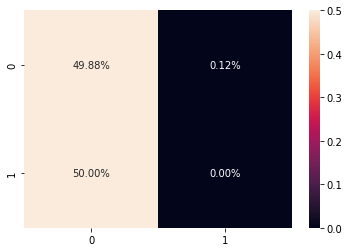

In [21]:
y_pred = data_st['cluster_labels']
y_true = data_st['Status']
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')

In [22]:
class_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       413
           1       0.00      0.00      0.00       413

    accuracy                           0.50       826
   macro avg       0.25      0.50      0.33       826
weighted avg       0.25      0.50      0.33       826



### 4.2. Clustering de unión completa 

In [23]:
# matriz de distancias
distance_matrix = linkage(scaled_data, method = 'complete', metric = 'euclidean')

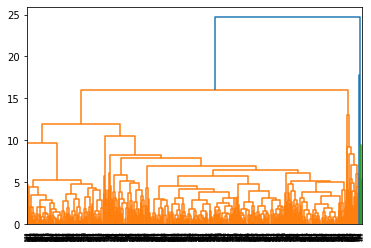

In [24]:
# crear dendrograma
dn = dendrogram(distance_matrix)
plt.show()

In [25]:
data_st['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')

Text(0.5, 1.0, 'Hierarchical')

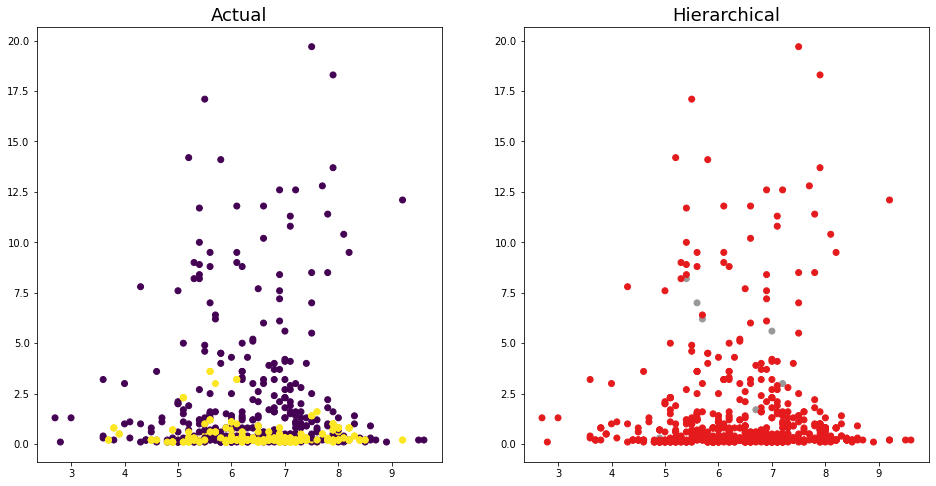

In [26]:
data_st['Status'] = technique.Status
 
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(data_st['TP'], data_st['DB'], c=data_st['Status'])
axes[1].scatter(data_st['TP'], data_st['DB'], c=data_st['cluster_labels'], cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Hierarchical', fontsize=18)

<AxesSubplot:>

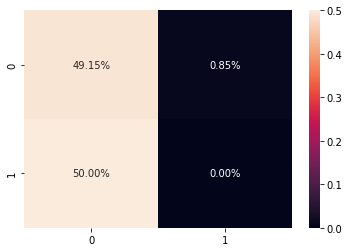

In [27]:
y_pred = data_st['cluster_labels']
y_true = data_st['Status']
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')

In [28]:
class_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.50      0.98      0.66       413
           1       0.00      0.00      0.00       413

    accuracy                           0.49       826
   macro avg       0.25      0.49      0.33       826
weighted avg       0.25      0.49      0.33       826



### 4.3. Clustering de unión media

In [29]:
# matriz de distancias
distance_matrix = linkage(scaled_data, method = 'average', metric = 'euclidean')

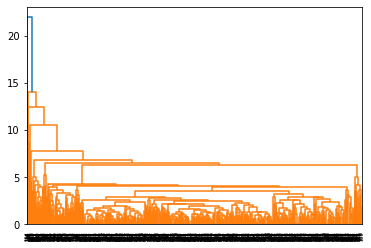

In [30]:
# crear dendrograma
dn = dendrogram(distance_matrix)
plt.show()

In [31]:
data_st['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')

Text(0.5, 1.0, 'Hierarchical')

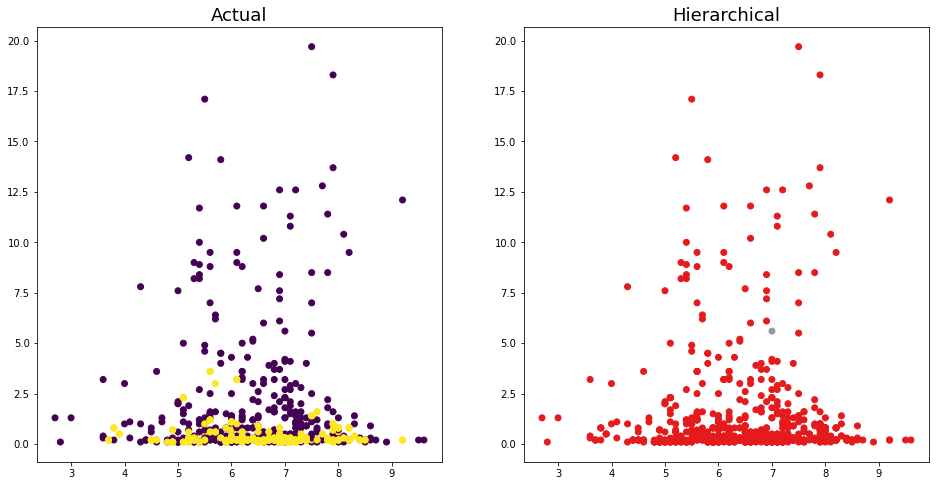

In [32]:
data_st['Status'] = technique.Status
 
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(data_st['TP'], data_st['DB'], c=data_st['Status'])
axes[1].scatter(data_st['TP'], data_st['DB'], c=data_st['cluster_labels'], cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Hierarchical', fontsize=18)

<AxesSubplot:>

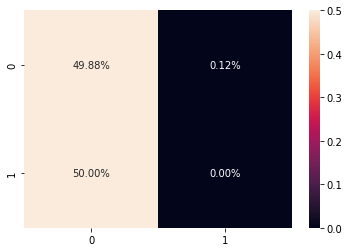

In [33]:
y_pred = data_st['cluster_labels']
y_true = data_st['Status']
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')

In [34]:
class_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       413
           1       0.00      0.00      0.00       413

    accuracy                           0.50       826
   macro avg       0.25      0.50      0.33       826
weighted avg       0.25      0.50      0.33       826



### 4.4. Clustering de unión de centroides

In [35]:
# matriz de distancias 
distance_matrix = linkage(scaled_data, method = 'centroid', metric = 'euclidean')

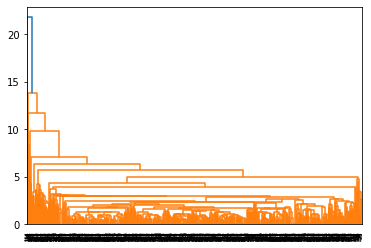

In [36]:
# crear dendrograma 
dn = dendrogram(distance_matrix)
plt.show()

In [37]:
data_st['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')

Text(0.5, 1.0, 'Hierarchical')

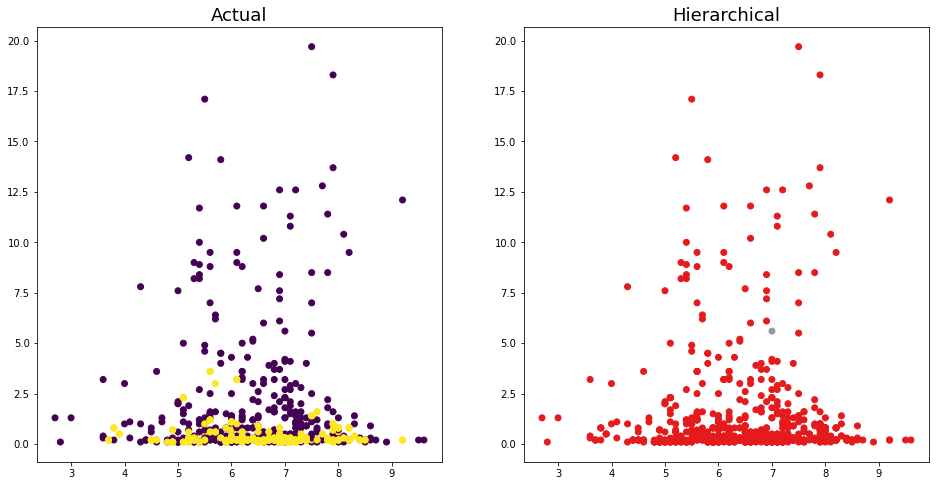

In [38]:
data_st['Status'] = technique.Status
 
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(data_st['TP'], data_st['DB'], c=data_st['Status'])
axes[1].scatter(data_st['TP'], data_st['DB'], c=data_st['cluster_labels'], cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Hierarchical', fontsize=18)

<AxesSubplot:>

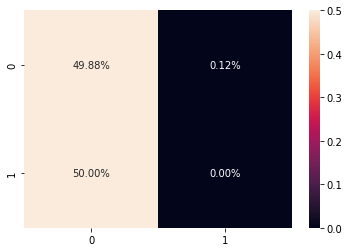

In [39]:
y_pred = data_st['cluster_labels']
y_true = data_st['Status']
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')

In [40]:
class_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       413
           1       0.00      0.00      0.00       413

    accuracy                           0.50       826
   macro avg       0.25      0.50      0.33       826
weighted avg       0.25      0.50      0.33       826



### 4.5. Clustering por distancia de Ward 

In [41]:
# matriz de distancia 
distance_matrix = linkage(scaled_data, method = 'ward', metric = 'euclidean')

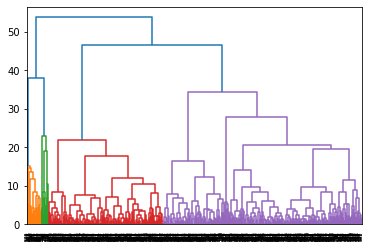

In [42]:
# Crear dendrograma 
dn = dendrogram(distance_matrix)
plt.show()

In [43]:
k=2
data_st['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')

Text(0.5, 1.0, 'Hierarchical')

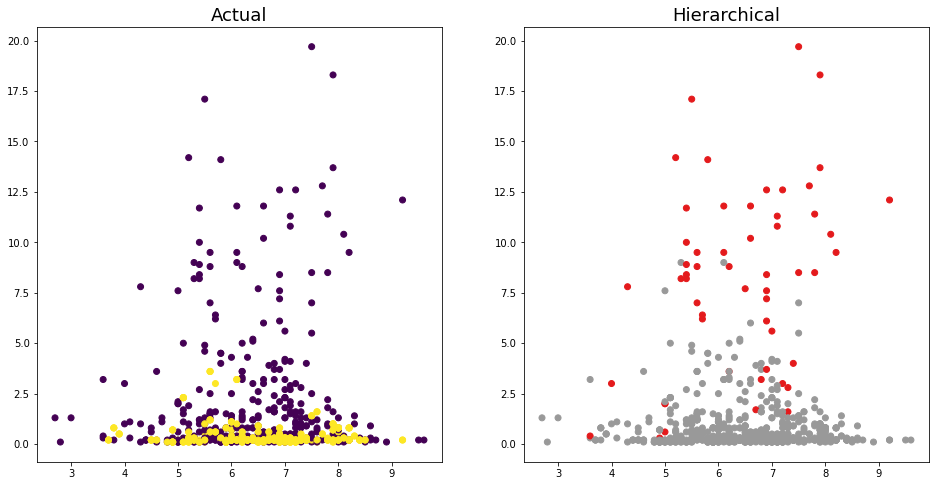

In [44]:
data_st['Status'] = technique.Status
 
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(data_st['TP'], data_st['DB'], c=data_st['Status'])
axes[1].scatter(data_st['TP'], data_st['DB'], c=data_st['cluster_labels'], cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Hierarchical', fontsize=18)

<AxesSubplot:>

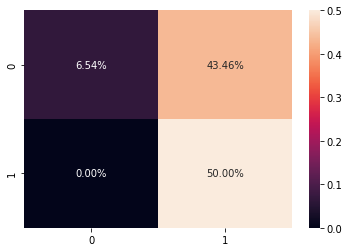

In [45]:
y_pred = data_st['cluster_labels']
y_true = data_st['Status']
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%')

In [46]:
class_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       1.00      0.13      0.23       413
           1       0.53      1.00      0.70       413

    accuracy                           0.57       826
   macro avg       0.77      0.57      0.46       826
weighted avg       0.77      0.57      0.46       826

